In [1]:
import pandas as pd
import numpy as np
import re
import json
import ollama
import chromadb
import time
from openai import OpenAI
import os

# GPT API

In [2]:
gpt = OpenAI(
    # 将这里换成你在便携AI聚合API后台生成的令牌
    api_key="sk-cklA0a53iPtuuL6SqFcn78ElW38iPQ8agPmj1ps2DRiyEMXY",
    # 这里将官方的接口访问地址替换成便携AI聚合API的入口地址
    base_url="https://api.bianxie.ai/v1"
)

completion = gpt.chat.completions.create(
    model="gpt-4o-mini-2024-07-18",
    messages=[
        {
            "role": "user",
            "content": "Who are you",
        }
    ]
)
print(completion.choices[0].message.content)

I am an AI language model created by OpenAI, designed to assist with a wide range of questions and tasks by providing information and generating text based on the input I receive. How can I help you today?


# qwen API

In [2]:
qwen = OpenAI(
    # 若没有配置环境变量，请用百炼API Key将下行替换为：api_key="sk-xxx",
    api_key="sk-bbf9f24ff4194920a43e15749a2dad29",
    base_url="https://dashscope.aliyuncs.com/compatible-mode/v1",
)
# 模型列表：https://help.aliyun.com/zh/model-studio/getting-started/models

# completion = qwen.chat.completions.create(
#     model="qwen2.5-72b-instruct", 
#     messages=[
#         {'role': 'system', 'content': 'You are a helpful assistant.'},
#         {'role': 'user', 'content': 'Are you qwen2.5-72b?'},],
#     )

# output_test = completion.choices[0].message.content
# print(output_test)

In [3]:
def load_data(file_path):
    df = pd.read_csv(file_path)
    df.dropna(inplace=True)

    def interpret_brightness(brightness_level):
        if 0 <= brightness_level <= 100:
            return "dark"
        elif 100 < brightness_level <= 150:
            return "dim"
        elif 150 < brightness_level <= 500:
            return "normal lighting"
        elif 500 < brightness_level <= 1000:
            return "very bright"
        else:
            return "dark"

    def generate_description(row):
        brightness_description = interpret_brightness(row['BrightnessLevel'])
        # return f"{row['UserActivity']} in the {row['Location']} when it is {brightness_description} at {row['Timestamp']}."
        pd.set_option('display.max_colwidth', None)
        description = f"{row['UserActivity']} in the {row['Location']} at {row['Timestamp']} when the environment is {brightness_description}."
        return description

    df['Description'] = df.apply(generate_description, axis=1)

    # only use the lastest state
    df_latest = df.iloc[-1:]
    df_latest = df_latest['Description']
    df_latest = df_latest.to_string(index=False)
    # print(df_latest)

    # use last 10 states
    df_history = df.iloc[-10:]
    df_history = df_history['Description']
    df_history = df_history.to_string(index=False)
    # print(df_history)

    return df_latest, df_history

def extract_json_from_response(response_text):
    """
    Extracts the JSON object from the assistant's response.
    """
    import json

    brace_count = 0
    json_start = None

    for i, char in enumerate(response_text):
        if char == '{':
            if brace_count == 0:
                json_start = i
            brace_count += 1
        elif char == '}':
            brace_count -= 1
            if brace_count == 0 and json_start is not None:
                json_str = response_text[json_start:i+1]
                try:
                    # Try to parse the extracted string
                    json.loads(json_str)
                    return json_str
                except json.JSONDecodeError:
                    pass  # Continue searching for valid JSON
    raise ValueError("No valid JSON object found in the assistant's response.")


    
def LLM2(knowledge_base, df_latest, collection, df_history, light_status):

    user_query = f"""
    There are 5 lights in the living room. light1 in the main light which has 3 color temperatures, warm, neutral and cool. light2 is a normalming light above the TV. light3 is a lamp on the table. light4 a super thin curtain on a big French window of living room. light5 is the main light in the dining room next to living room closely.
    Now the light status is {light_status}, recent user behaviors are: {df_history}, tell me Which lights should be turned on/off while the user is {df_latest}? "
    """ 

    print("User Query:")
    print(user_query)

    query_response = ollama.embeddings(
        prompt=user_query,
        model="mxbai-embed-large"
    )

    results = collection.query(
        query_embeddings=[query_response["embedding"]],
        n_results= 30  # Retrieve top 10 relevant documents
    )

    retrieved_documents = results['documents'][0]  
    data = ' '.join(retrieved_documents)
    print("Retrieved Data:")
    print(data)

    final_prompt = f"""
You are an AI smart home assistant.

Your task is to determine the appropriate light control actions based on the user's current situation and preferences.

**Instructions:**

1. **Analyze the user's current situation:**
   - Activity: {df_latest}
   - Current light status: {light_status}
   - Recent user behaviors: {df_history}
   consider the recent user behaviors, there are some trasitional phase, like from eating to sitting to eating, sitting only lasts for a very short period of time, so dont have to update sitting, here dont update knowledge base of sitting decide which lights should be turned on or off based on these preferences.

2. **Also refer to the knowledge base entries below to understand the user's preferences:**
{data}

3. **Determine the appropriate light control actions:**
   - Map the user's activity to their preferences.
   - Decide which lights should be turned on or off based on these preferences.

4. **Output the light control actions in the fixed JSON format below:**

```json
{{
    "description": "{df_latest}",
    "light1": "on/off",
    "light2": "on/off",
    "light3": "on/off",
    "light4": "open/close",
    "light5": "on/off"
}}
    """

    # output = ollama.generate(
    #     # model="qwen2.5:7b",
    #     model ="qwen2.5:14b-instruct",
    #     prompt=final_prompt
    # )
    # assistant_response = output['response']

    completion = gpt.chat.completions.create(
    model="gpt-4o-mini-2024-07-18",
    messages=[
        {'role': 'system', 'content': 'You are a helpful AI smart home assistant.'},
        {'role': 'user', 'content': final_prompt},],
    )
    assistant_response = completion.choices[0].message.content

    print("Assistant's Response:")
    print(assistant_response)

    try:
        # Extract JSON code block if the assistant included any text before or after
        json_code = extract_json_from_response(assistant_response)

        # Parse the JSON string
        actions = json.loads(json_code)

        # Remove the "description" key if not needed
        actions.pop("description", None)

        print("\nExtracted Light Control Actions:")
        print(actions)

        return actions

    except json.JSONDecodeError as e:
        print(f"JSON parsing error: {e}")
        # Handle the error or return None
        return None



def LLM1(df_latest, user_feedback, actions, df_history, collection):
    print("User Feedback:")
    print(user_feedback)
    
    user_update = f"""
    You are a smart home assistant responsible for deciding if to update the lighting knowledge based on user manually changes to the light states. 
    The user manually change the current light status from suggested action: {actions} to: {user_feedback}. The recent 10 user behaviors are {df_history}.
    Considering recent user behaviors, there are some trasition activities (between 2 steady activities), so decide if to update the knowledge base based on the user feedback and recent behaviors.
    """

    query_response = ollama.embeddings(
        prompt=user_update,
        model="mxbai-embed-large"
    )

    results = collection.query(
        query_embeddings=[query_response["embedding"]],
        n_results=8  # Retrieve top 10 relevant documents
    )

    retrieved_documents = results['documents'][0]  
    data = ' '.join(retrieved_documents)
    print("Retrieved Data:")
    print(data)

    final_prompt_update = f"""
    You are a smart home assistant.

    Based on the retrieved current knowledge base entries:
    {data}

    Consider current situation:
    {user_update}

    Decide if to update the knowledge base in the fixed json format:
    {{
    "Update": "yes/no"  
    }}

    Provide the updated knowledge base in the fixed json format:
    {{
        "{df_latest}:",
        "light1": "on/off",
        "light2": "on/off",
        "light3": "on/off",
        "light4": "open/close",
        "light5": "on/off",

    }}
    """

    ## LLM1
    # output = ollama.generate(
    # model="qwen2.5:14b-instruct",
    # prompt=final_prompt_update
    # )
    # knowledge_base_text = output['response']

    completion = gpt.chat.completions.create(
    model="gpt-4o-mini-2024-07-18",
    messages=[
        {'role': 'system', 'content': 'You are a helpful AI smart home assistant.'},
        {'role': 'user', 'content': final_prompt_update},],
    )

    print("Assistant's Response:")
    print(completion.choices[0].message.content)
    knowledge_base_text = completion.choices[0].message.content
    
    # print(knowledge_base_text)
    return knowledge_base_text


def extract_json_objects(text):
    """
    Extracts all JSON objects from the text.
    """
    json_objects = []
    brace_stack = []
    in_json = False
    json_start = 0

    for i, char in enumerate(text):
        if char == '{':
            if not in_json:
                json_start = i
                in_json = True
            brace_stack.append('{')
        elif char == '}':
            if brace_stack:
                brace_stack.pop()
                if not brace_stack:
                    # Found a complete JSON object
                    json_str = text[json_start:i+1]
                    json_objects.append(json_str)
                    in_json = False
        else:
            continue

    return json_objects

def update_knowledge_base(knowledge_base, knowledge_base_update):
    code_block_pattern = r'```json\s*([\s\S]*?)```'
    json_blocks = re.findall(code_block_pattern, knowledge_base_update)

    if not json_blocks:
        # Try to find any JSON objects in the text
        # json_blocks = re.findall(r'\{(?:[^{}]|(?R))*\}', knowledge_base_update)
        json_blocks = extract_json_objects(knowledge_base_update)

    update_decision = None
    updated_kb = None

    for idx, json_str in enumerate(json_blocks):
        print(f"\nExtracted JSON String {idx+1}:")
        print(json_str)

        # Clean up the JSON string
        json_str = json_str.strip()
        json_str = re.sub(r',\s*}', '}', json_str)  # Remove trailing commas before }
        json_str = re.sub(r',\s*\]', ']', json_str)  # Remove trailing commas before ]

        # Parse the JSON string
        try:
            json_data = json.loads(json_str)

            if "Update" in json_data:
                update_decision = json_data.get("Update")
                print(f"\nParsed Update Decision: {update_decision}")

                json_data.pop("Update", None)

                if json_data:
                    updated_kb = json_data
                    print("\nParsed Updated Knowledge Base:")
                    print(json.dumps(updated_kb, indent=2))
            else:
                updated_kb = json_data
                print("\nParsed Updated Knowledge Base:")
                print(json.dumps(updated_kb, indent=2))
        except json.JSONDecodeError as e:
            print(f"\nFailed to parse JSON in block {idx+1}: {e}")

    # Process the extracted data
    if update_decision is not None:
        print(f"\nUpdate Decision: {update_decision}")
        if update_decision.lower() == "yes":
            if updated_kb is not None:
                # light_status = updated_kb.get("description")
                knowledge_base = knowledge_base + "\n" + json.dumps(updated_kb, indent=2)
                print("\nKnowledge base has been updated.")
            else:
                print("\nNo updated knowledge base provided.")
        else:
            print("\nKnowledge base remains unchanged.")
    else:
        print("\nThe 'Update' decision was not found in the LLM's output.")

    return knowledge_base, update_decision


def get_user_confidence():
    confidence_input = input("Please rate your confidence in the system on a scale from 0 to 1: ")
    try:
        confidence = float(confidence_input)
        if 0 <= confidence <= 1:
            return confidence
        else:
            print("Invalid input. Confidence should be between 0 and 1.")
            return get_user_confidence()
    except ValueError:
        print("Invalid input. Please enter a number between 0 and 1.")
        return get_user_confidence()

knowledge_base = """
    This is the preference of the user.

    Prefer a bright lit while watching TV.

    Prefer a bright lit environment while reading books.

    Prefer a bright lit environment while exercising.

    Prefer a bright lit environment while eating.

    Prefer a bright lit environment while playing video games.

    Prefer a dark environment while lying. 

    Prefer a bright lit environment while exercising.

    Prefer a bright lit environment while housekeeping.

    Prefer a bright lit environment while typing.

    Prefer a bright lit environment while sitting.

    Prefer a bright lit environment while cooking.

    Prefer a bright lit environment while grooming.
"""

In [6]:
knowledge_base = ''''
    This is the preference of the user.

    Prefer a normally lit while watching TV.

    Prefer a dimly lit environment while reading books.

    Prefer a bright environment while exercising.

    Prefer a bright environment while eating.

    Prefer a dimly lit environment while playing video games.

    Prefer a dark environment while lying. 

    Prefer a bright environment while exercising.

    Prefer a bright environment while housekeeping.

    Prefer a dimly lit environment while typing.

    Prefer a dimly lit environment while sitting.

    Prefer a bright environment while cooking.

    Prefer a bright environment while grooming.
{
  "housekeeping in the living room at 11:03:30 when it is very bright.": {
    "light1": "off",
    "light2": "off",
    "light3": "off",
    "light4": "open",
    "light5": "off"
  }
}
{
  "walking in the living room at 10:58:30 when it is very bright.": {
    "light1": "off",
    "light2": "off",
    "light3": "off",
    "light4": "close",
    "light5": "off"
  }
}
{
  "typing in the sofa at 10:48:00 when it is very bright.": {
    "light1": "off",
    "light2": "off",
    "light3": "off",
    "light4": "close",
    "light5": "off"
  }
}
{
  "video_gaming in the sofa at 10:42:30 when it is very bright.": {
    "light1": "off",
    "light2": "off",
    "light3": "off",
    "light4": "close",
    "light5": "off"
  }
}
{
  "watching_tv in the sofa at 10:37:00 when it is very bright.": {
    "light1": "off",
    "light2": "off",
    "light3": "off",
    "light4": "close",
    "light5": "off"
  }
}
{
  "lying in the sofa at 10:32:00 when it is very bright.": {
    "light1": "off",
    "light2": "off",
    "light3": "off",
    "light4": "close",
    "light5": "off"
  }
}
{
  "eating in the sofa at 10:32:00 when it is very bright.": {
    "light1": "off",
    "light2": "off",
    "light3": "off",
    "light4": "close",
    "light5": "off"
  }
}
'''

In [4]:
documents = knowledge_base.split('\n\n')
documents = [' '.join(doc.split()) for doc in documents]

client = chromadb.Client()

try:
    collection = client.get_collection("docs")
    print("Collection already exists.")
except Exception as e:
    # If the collection does not exist, create it
    collection = client.create_collection(name="docs")
    print("Collection created.")

# store each document in a vector embedding database
for i, d in enumerate(documents):
    response = ollama.embeddings(model="mxbai-embed-large", prompt=d)
    embedding = response["embedding"]
    collection.add(
        ids=[str(i)],
        embeddings=[embedding],
        documents=[d]
    )


def main():
    global knowledge_base
    previous_df_latest = None

    user = "Richard"
    light_status = {
        "light1": "off",
        "light2": "off",
        "light3": "off",
        "light4": "close",
        "light5": "off"
    }

    while True:
        df_latest, df_history = load_data('simulated_data/reading.csv')

        # check if df_latest changed
        if df_latest != previous_df_latest:
            print("description changed")
            print(df_latest)
            
            actions = LLM2(knowledge_base, df_latest, collection, df_history, light_status)
            print("\nSuggested Action:")
            print(actions)

            user_feedback_input = input("Enter user feedback as a JSON string (or leave empty): ")
            # format: {"light1": "on", "light2": "on", "light3": "off", "light4": "close", "light5": "on"}
            if user_feedback_input:
                try:
                    user_feedback = json.loads(user_feedback_input)
                except json.JSONDecodeError:
                    print("Invalid JSON input. Please try again.")
                    # user_feedback = None
                    continue
            else:
                user_feedback = None

            if user_feedback:
                user_condidence = get_user_confidence()
                # if user_condidence < 0.5:
                #     # use RL agent to update the knowledge base
                #     print("RL agent to update the knowledge base")
                #     knowledge_base = rl_agent_update(knowledge_base, user_feedback, actions, df_history)

                # else:

                knowledge_base_update = LLM1(
                    df_latest=df_latest,
                    user_feedback=user_feedback,
                    actions=actions,
                    df_history=df_history,
                    collection=collection)
                
                knowledge_base, update_decision = update_knowledge_base(knowledge_base, knowledge_base_update)
                print("\nUpdated Knowledge Base:")
                print(knowledge_base)

                if update_decision == "yes":
                    light_status = user_feedback
                    print("\nUpdated Light Status:")
                    print(light_status)
                else:
                    print("\nLight Status remains unchanged.")
                    light_status = actions

            previous_df_latest = df_latest
        else:
            print("description not changed")
        
        time.sleep(10)

if __name__ == "__main__":
    main()

Collection created.


Number of requested results 30 is greater than number of elements in index 13, updating n_results = 13


description changed
sitting in the sofa at 10:21:30 when the environment is dim.
User Query:

    There are 5 lights in the living room. light1 in the main light which has 3 color temperatures, warm, neutral and cool. light2 is a normalming light above the TV. light3 is a lamp on the table. light4 a super thin curtain on a big French window of living room. light5 is the main light in the dining room next to living room closely.
    Now the light status is {'light1': 'off', 'light2': 'off', 'light3': 'off', 'light4': 'close', 'light5': 'off'}, recent user behaviors are: sitting in the sofa at 10:08:00 when the environment is dim.
sitting in the sofa at 10:10:00 when the environment is dim.
sitting in the sofa at 10:12:00 when the environment is dim.
sitting in the sofa at 10:14:00 when the environment is dim.
sitting in the sofa at 10:16:00 when the environment is dim.
sitting in the sofa at 10:18:00 when the environment is dim.
sitting in the sofa at 10:19:00 when the environment is di

Number of requested results 30 is greater than number of elements in index 13, updating n_results = 13


Retrieved Data:
Prefer a bright lit environment while housekeeping. Prefer a bright lit environment while sitting. Prefer a bright lit environment while reading books. Prefer a bright lit while watching TV. Prefer a bright lit environment while typing. Prefer a bright lit environment while grooming. Prefer a bright lit environment while cooking. Prefer a bright lit environment while eating. Prefer a dark environment while lying. Prefer a bright lit environment while playing video games. Prefer a bright lit environment while exercising. Prefer a bright lit environment while exercising. This is the preference of the user.
Assistant's Response:
Based on the user's activity of reading in the sofa and their preference for a bright lit environment while reading, I recommend turning on the lights to enhance illumination.

Assuming that at least one of the lights is suitable for reading, I will turn on the lights. The current status shows all lights are off, and the fourth light, which is clos

Number of requested results 30 is greater than number of elements in index 13, updating n_results = 13


description changed
lying in the sofa at 10:32:00 when the environment is dim.
User Query:

    There are 5 lights in the living room. light1 in the main light which has 3 color temperatures, warm, neutral and cool. light2 is a normalming light above the TV. light3 is a lamp on the table. light4 a super thin curtain on a big French window of living room. light5 is the main light in the dining room next to living room closely.
    Now the light status is {'light1': 'off', 'light2': 'off', 'light3': 'off', 'light4': 'close', 'light5': 'off'}, recent user behaviors are: lying in the sofa at 10:27:30 when the environment is dim.
lying in the sofa at 10:28:00 when the environment is dim.
lying in the sofa at 10:28:30 when the environment is dim.
lying in the sofa at 10:29:00 when the environment is dim.
lying in the sofa at 10:29:30 when the environment is dim.
lying in the sofa at 10:30:00 when the environment is dim.
lying in the sofa at 10:30:30 when the environment is dim.
lying in the 

Number of requested results 30 is greater than number of elements in index 13, updating n_results = 13


description changed
watching_tv in the sofa at 10:37:00 when the environment is dim.
User Query:

    There are 5 lights in the living room. light1 in the main light which has 3 color temperatures, warm, neutral and cool. light2 is a normalming light above the TV. light3 is a lamp on the table. light4 a super thin curtain on a big French window of living room. light5 is the main light in the dining room next to living room closely.
    Now the light status is {'light1': 'off', 'light2': 'off', 'light3': 'off', 'light4': 'close', 'light5': 'off'}, recent user behaviors are: watching_tv in the sofa at 10:32:30 when the environment is dim.
watching_tv in the sofa at 10:33:00 when the environment is dim.
watching_tv in the sofa at 10:33:30 when the environment is dim.
watching_tv in the sofa at 10:34:00 when the environment is dim.
watching_tv in the sofa at 10:34:30 when the environment is dim.
watching_tv in the sofa at 10:35:00 when the environment is dim.
watching_tv in the sofa at 10:

Number of requested results 30 is greater than number of elements in index 13, updating n_results = 13


Retrieved Data:
Prefer a bright lit environment while playing video games. Prefer a bright lit environment while housekeeping. Prefer a bright lit environment while sitting. Prefer a bright lit environment while typing. Prefer a bright lit while watching TV. Prefer a bright lit environment while grooming. Prefer a dark environment while lying. Prefer a bright lit environment while cooking. Prefer a bright lit environment while eating. Prefer a bright lit environment while exercising. Prefer a bright lit environment while exercising. This is the preference of the user. Prefer a bright lit environment while reading books.
Assistant's Response:
```json
{
    "description": "video_gaming in the sofa at 10:42:30 when the environment is dim.",
    "light1": "on",
    "light2": "on",
    "light3": "on",
    "light4": "open",
    "light5": "on"
}
```

Extracted Light Control Actions:
{'light1': 'on', 'light2': 'on', 'light3': 'on', 'light4': 'open', 'light5': 'on'}

Suggested Action:
{'light1'

Number of requested results 30 is greater than number of elements in index 13, updating n_results = 13


description changed
typing in the sofa at 10:48:00 when the environment is dim.
User Query:

    There are 5 lights in the living room. light1 in the main light which has 3 color temperatures, warm, neutral and cool. light2 is a normalming light above the TV. light3 is a lamp on the table. light4 a super thin curtain on a big French window of living room. light5 is the main light in the dining room next to living room closely.
    Now the light status is {'light1': 'off', 'light2': 'off', 'light3': 'off', 'light4': 'close', 'light5': 'off'}, recent user behaviors are: typing in the sofa at 10:43:30 when the environment is dim.
typing in the sofa at 10:44:00 when the environment is dim.
typing in the sofa at 10:44:30 when the environment is dim.
typing in the sofa at 10:45:00 when the environment is dim.
typing in the sofa at 10:45:30 when the environment is dim.
typing in the sofa at 10:46:00 when the environment is dim.
typing in the sofa at 10:46:30 when the environment is dim.
typin

Number of requested results 30 is greater than number of elements in index 13, updating n_results = 13


Retrieved Data:
Prefer a bright lit environment while eating. Prefer a bright lit environment while housekeeping. Prefer a bright lit environment while sitting. Prefer a bright lit environment while cooking. Prefer a bright lit environment while grooming. Prefer a bright lit while watching TV. Prefer a dark environment while lying. Prefer a bright lit environment while typing. Prefer a bright lit environment while playing video games. Prefer a bright lit environment while exercising. Prefer a bright lit environment while exercising. Prefer a bright lit environment while reading books. This is the preference of the user.
Assistant's Response:
Based on the user's current situation of eating in the sofa at 10:53:30 in a dim environment, and considering their preference for a bright lit environment while eating, the appropriate light control actions would be:

```json
{
    "description": "eating in the sofa at 10:53:30 when the environment is dim.",
    "light1": "on",
    "light2": "on",

Number of requested results 30 is greater than number of elements in index 13, updating n_results = 13


Retrieved Data:
Prefer a bright lit environment while housekeeping. Prefer a bright lit environment while sitting. Prefer a bright lit environment while grooming. Prefer a bright lit environment while cooking. Prefer a bright lit environment while exercising. Prefer a bright lit environment while exercising. Prefer a bright lit environment while eating. Prefer a bright lit while watching TV. Prefer a bright lit environment while typing. Prefer a dark environment while lying. Prefer a bright lit environment while playing video games. Prefer a bright lit environment while reading books. This is the preference of the user.
Assistant's Response:
```json
{
    "description": "walking in the living room at 10:58:30 when the environment is dim.",
    "light1": "on",
    "light2": "on",
    "light3": "on",
    "light4": "close",
    "light5": "off"
}
```

Extracted Light Control Actions:
{'light1': 'on', 'light2': 'on', 'light3': 'on', 'light4': 'close', 'light5': 'off'}

Suggested Action:
{'l

Number of requested results 30 is greater than number of elements in index 13, updating n_results = 13


description changed
housekeeping in the living room at 11:03:30 when the environment is dim.
User Query:

    There are 5 lights in the living room. light1 in the main light which has 3 color temperatures, warm, neutral and cool. light2 is a normalming light above the TV. light3 is a lamp on the table. light4 a super thin curtain on a big French window of living room. light5 is the main light in the dining room next to living room closely.
    Now the light status is {'light1': 'off', 'light2': 'off', 'light3': 'off', 'light4': 'close', 'light5': 'off'}, recent user behaviors are: housekeeping in the living room at 10:59:00 when the environment is dim.
housekeeping in the living room at 10:59:30 when the environment is dim.
housekeeping in the living room at 11:00:00 when the environment is dim.
housekeeping in the living room at 11:00:30 when the environment is dim.
housekeeping in the living room at 11:01:00 when the environment is dim.
housekeeping in the living room at 11:01:30 whe

Number of requested results 30 is greater than number of elements in index 13, updating n_results = 13


Retrieved Data:
Prefer a bright lit environment while exercising. Prefer a bright lit environment while exercising. Prefer a bright lit environment while housekeeping. Prefer a bright lit environment while sitting. Prefer a bright lit environment while grooming. Prefer a bright lit environment while typing. Prefer a bright lit environment while cooking. Prefer a bright lit environment while eating. Prefer a bright lit while watching TV. Prefer a bright lit environment while playing video games. Prefer a dark environment while lying. Prefer a bright lit environment while reading books. This is the preference of the user.
Assistant's Response:
```json
{
    "description": "exercising in the living room at 11:09:00 when the environment is dim.",
    "light1": "on",
    "light2": "on",
    "light3": "on",
    "light4": "open",
    "light5": "on"
}
```

Extracted Light Control Actions:
{'light1': 'on', 'light2': 'on', 'light3': 'on', 'light4': 'open', 'light5': 'on'}

Suggested Action:
{'li

Number of requested results 30 is greater than number of elements in index 13, updating n_results = 13


Retrieved Data:
Prefer a bright lit environment while sitting. Prefer a bright lit environment while housekeeping. Prefer a dark environment while lying. Prefer a bright lit environment while eating. Prefer a bright lit while watching TV. Prefer a bright lit environment while grooming. Prefer a bright lit environment while cooking. Prefer a bright lit environment while typing. Prefer a bright lit environment while playing video games. Prefer a bright lit environment while exercising. Prefer a bright lit environment while exercising. Prefer a bright lit environment while reading books. This is the preference of the user.
Assistant's Response:
```json
{
    "description": "sitting in the sofa at 10:21:30 when the environment is dark.",
    "light1": "on",
    "light2": "on",
    "light3": "on",
    "light4": "close",
    "light5": "off"
}
```

Extracted Light Control Actions:
{'light1': 'on', 'light2': 'on', 'light3': 'on', 'light4': 'close', 'light5': 'off'}

Suggested Action:
{'light1'

Number of requested results 30 is greater than number of elements in index 13, updating n_results = 13


Retrieved Data:
Prefer a bright lit environment while housekeeping. Prefer a bright lit environment while sitting. Prefer a bright lit environment while reading books. Prefer a bright lit while watching TV. Prefer a bright lit environment while typing. Prefer a dark environment while lying. Prefer a bright lit environment while cooking. Prefer a bright lit environment while grooming. Prefer a bright lit environment while eating. Prefer a bright lit environment while playing video games. Prefer a bright lit environment while exercising. Prefer a bright lit environment while exercising. This is the preference of the user.
Assistant's Response:
```json
{
    "description": "reading in the sofa at 10:26:30 when the environment is dark.",
    "light1": "on",
    "light2": "on",
    "light3": "on",
    "light4": "close",
    "light5": "off"
}
```

Extracted Light Control Actions:
{'light1': 'on', 'light2': 'on', 'light3': 'on', 'light4': 'close', 'light5': 'off'}

Suggested Action:
{'light1'

Number of requested results 30 is greater than number of elements in index 13, updating n_results = 13


description changed
watching_tv in the sofa at 10:37:00 when the environment is dark.
User Query:

    There are 5 lights in the living room. light1 in the main light which has 3 color temperatures, warm, neutral and cool. light2 is a normalming light above the TV. light3 is a lamp on the table. light4 a super thin curtain on a big French window of living room. light5 is the main light in the dining room next to living room closely.
    Now the light status is {'light1': 'off', 'light2': 'off', 'light3': 'off', 'light4': 'close', 'light5': 'off'}, recent user behaviors are: watching_tv in the sofa at 10:32:30 when the environment is dark.
watching_tv in the sofa at 10:33:00 when the environment is dark.
watching_tv in the sofa at 10:33:30 when the environment is dark.
watching_tv in the sofa at 10:34:00 when the environment is dark.
watching_tv in the sofa at 10:34:30 when the environment is dark.
watching_tv in the sofa at 10:35:00 when the environment is dark.
watching_tv in the sofa

Number of requested results 30 is greater than number of elements in index 13, updating n_results = 13


description changed
video_gaming in the sofa at 10:42:30 when the environment is dark.
User Query:

    There are 5 lights in the living room. light1 in the main light which has 3 color temperatures, warm, neutral and cool. light2 is a normalming light above the TV. light3 is a lamp on the table. light4 a super thin curtain on a big French window of living room. light5 is the main light in the dining room next to living room closely.
    Now the light status is {'light1': 'off', 'light2': 'off', 'light3': 'off', 'light4': 'close', 'light5': 'off'}, recent user behaviors are: video_gaming in the sofa at 10:38:00 when the environment is dark.
video_gaming in the sofa at 10:38:30 when the environment is dark.
video_gaming in the sofa at 10:39:00 when the environment is dark.
video_gaming in the sofa at 10:39:30 when the environment is dark.
video_gaming in the sofa at 10:40:00 when the environment is dark.
video_gaming in the sofa at 10:40:30 when the environment is dark.
video_gaming in 

Number of requested results 30 is greater than number of elements in index 13, updating n_results = 13


description changed
typing in the sofa at 10:48:00 when the environment is dark.
User Query:

    There are 5 lights in the living room. light1 in the main light which has 3 color temperatures, warm, neutral and cool. light2 is a normalming light above the TV. light3 is a lamp on the table. light4 a super thin curtain on a big French window of living room. light5 is the main light in the dining room next to living room closely.
    Now the light status is {'light1': 'off', 'light2': 'off', 'light3': 'off', 'light4': 'close', 'light5': 'off'}, recent user behaviors are: typing in the sofa at 10:43:30 when the environment is dark.
typing in the sofa at 10:44:00 when the environment is dark.
typing in the sofa at 10:44:30 when the environment is dark.
typing in the sofa at 10:45:00 when the environment is dark.
typing in the sofa at 10:45:30 when the environment is dark.
typing in the sofa at 10:46:00 when the environment is dark.
typing in the sofa at 10:46:30 when the environment is dar

Number of requested results 30 is greater than number of elements in index 13, updating n_results = 13


Retrieved Data:
Prefer a bright lit environment while eating. Prefer a bright lit environment while housekeeping. Prefer a bright lit environment while sitting. Prefer a bright lit environment while cooking. Prefer a dark environment while lying. Prefer a bright lit environment while grooming. Prefer a bright lit while watching TV. Prefer a bright lit environment while typing. Prefer a bright lit environment while playing video games. Prefer a bright lit environment while exercising. Prefer a bright lit environment while exercising. Prefer a bright lit environment while reading books. This is the preference of the user.
Assistant's Response:
```json
{
    "description": "eating in the sofa at 10:53:30 when the environment is dark.",
    "light1": "on",
    "light2": "on",
    "light3": "on",
    "light4": "close",
    "light5": "on"
}
```

Extracted Light Control Actions:
{'light1': 'on', 'light2': 'on', 'light3': 'on', 'light4': 'close', 'light5': 'on'}

Suggested Action:
{'light1': '

Number of requested results 30 is greater than number of elements in index 13, updating n_results = 13


Retrieved Data:
Prefer a bright lit environment while housekeeping. Prefer a bright lit environment while sitting. Prefer a bright lit environment while cooking. Prefer a bright lit environment while grooming. Prefer a bright lit environment while eating. Prefer a bright lit environment while exercising. Prefer a bright lit environment while exercising. Prefer a bright lit environment while typing. Prefer a bright lit while watching TV. Prefer a dark environment while lying. Prefer a bright lit environment while playing video games. Prefer a bright lit environment while reading books. This is the preference of the user.
Assistant's Response:
```json
{
    "description": "walking in the living room at 10:58:30 when the environment is dark.",
    "light1": "on",
    "light2": "on",
    "light3": "off",
    "light4": "close",
    "light5": "off"
}
```

Extracted Light Control Actions:
{'light1': 'on', 'light2': 'on', 'light3': 'off', 'light4': 'close', 'light5': 'off'}

Suggested Action:


Number of requested results 30 is greater than number of elements in index 13, updating n_results = 13


Retrieved Data:
Prefer a bright lit environment while housekeeping. Prefer a bright lit environment while grooming. Prefer a bright lit environment while sitting. Prefer a bright lit environment while cooking. Prefer a dark environment while lying. Prefer a bright lit while watching TV. Prefer a bright lit environment while typing. Prefer a bright lit environment while eating. Prefer a bright lit environment while playing video games. Prefer a bright lit environment while reading books. Prefer a bright lit environment while exercising. Prefer a bright lit environment while exercising. This is the preference of the user.
Assistant's Response:
```json
{
    "description": "housekeeping in the living room at 11:03:30 when the environment is dark.",
    "light1": "on",
    "light2": "on",
    "light3": "on",
    "light4": "close",
    "light5": "off"
}
```

Extracted Light Control Actions:
{'light1': 'on', 'light2': 'on', 'light3': 'on', 'light4': 'close', 'light5': 'off'}

Suggested Actio

Number of requested results 30 is greater than number of elements in index 13, updating n_results = 13


Retrieved Data:
Prefer a bright lit environment while exercising. Prefer a bright lit environment while exercising. Prefer a bright lit environment while housekeeping. Prefer a bright lit environment while sitting. Prefer a bright lit environment while grooming. Prefer a bright lit environment while typing. Prefer a bright lit environment while cooking. Prefer a bright lit environment while eating. Prefer a dark environment while lying. Prefer a bright lit while watching TV. Prefer a bright lit environment while playing video games. Prefer a bright lit environment while reading books. This is the preference of the user.
Assistant's Response:
Given the user's current situation of exercising in the living room at 11:09:00 when the environment is dark, and considering the user's preference for a bright environment while exercising, the appropriate light control actions are as follows:

1. Turn on all lights that are currently off.
2. No changes to the state of light4 as it is already mark

Number of requested results 30 is greater than number of elements in index 13, updating n_results = 13


Retrieved Data:
Prefer a bright lit environment while sitting. Prefer a bright lit environment while housekeeping. Prefer a bright lit environment while eating. Prefer a bright lit while watching TV. Prefer a bright lit environment while grooming. Prefer a bright lit environment while cooking. Prefer a dark environment while lying. Prefer a bright lit environment while typing. Prefer a bright lit environment while playing video games. Prefer a bright lit environment while exercising. Prefer a bright lit environment while exercising. Prefer a bright lit environment while reading books. This is the preference of the user.
Assistant's Response:
```json
{
    "description": "sitting in the sofa at 10:21:30 when the environment is very bright.",
    "light1": "on",
    "light2": "on",
    "light3": "on",
    "light4": "close",
    "light5": "off"
}
```

Extracted Light Control Actions:
{'light1': 'on', 'light2': 'on', 'light3': 'on', 'light4': 'close', 'light5': 'off'}

Suggested Action:
{'

Number of requested results 30 is greater than number of elements in index 13, updating n_results = 13


description changed
reading in the sofa at 10:26:30 when the environment is very bright.
User Query:

    There are 5 lights in the living room. light1 in the main light which has 3 color temperatures, warm, neutral and cool. light2 is a normalming light above the TV. light3 is a lamp on the table. light4 a super thin curtain on a big French window of living room. light5 is the main light in the dining room next to living room closely.
    Now the light status is {'light1': 'off', 'light2': 'off', 'light3': 'off', 'light4': 'close', 'light5': 'off'}, recent user behaviors are: reading in the sofa at 10:22:00 when the environment is very bright.
reading in the sofa at 10:22:30 when the environment is very bright.
reading in the sofa at 10:23:00 when the environment is very bright.
reading in the sofa at 10:23:30 when the environment is very bright.
reading in the sofa at 10:24:00 when the environment is very bright.
reading in the sofa at 10:24:30 when the environment is very bright.
re

Number of requested results 30 is greater than number of elements in index 13, updating n_results = 13


Retrieved Data:
Prefer a bright lit while watching TV. Prefer a bright lit environment while housekeeping. Prefer a bright lit environment while sitting. Prefer a bright lit environment while eating. Prefer a bright lit environment while cooking. Prefer a bright lit environment while grooming. Prefer a bright lit environment while typing. Prefer a bright lit environment while playing video games. Prefer a dark environment while lying. Prefer a bright lit environment while exercising. Prefer a bright lit environment while exercising. Prefer a bright lit environment while reading books. This is the preference of the user.
Assistant's Response:
```json
{
    "description": "watching_tv in the sofa at 10:37:00 when the environment is very bright.",
    "light1": "on",
    "light2": "on",
    "light3": "off",
    "light4": "close",
    "light5": "off"
}
```

Extracted Light Control Actions:
{'light1': 'on', 'light2': 'on', 'light3': 'off', 'light4': 'close', 'light5': 'off'}

Suggested Acti

Number of requested results 30 is greater than number of elements in index 13, updating n_results = 13


Retrieved Data:
Prefer a bright lit environment while playing video games. Prefer a bright lit environment while housekeeping. Prefer a bright lit environment while sitting. Prefer a bright lit while watching TV. Prefer a bright lit environment while typing. Prefer a bright lit environment while grooming. Prefer a bright lit environment while eating. Prefer a bright lit environment while cooking. Prefer a dark environment while lying. Prefer a bright lit environment while exercising. Prefer a bright lit environment while exercising. Prefer a bright lit environment while reading books. This is the preference of the user.
Assistant's Response:
```json
{
    "description": "video_gaming in the sofa at 10:42:30 when the environment is very bright.",
    "light1": "on",
    "light2": "on",
    "light3": "on",
    "light4": "open",
    "light5": "on"
}
```

Extracted Light Control Actions:
{'light1': 'on', 'light2': 'on', 'light3': 'on', 'light4': 'open', 'light5': 'on'}

Suggested Action:
{

Number of requested results 30 is greater than number of elements in index 13, updating n_results = 13


Retrieved Data:
Prefer a bright lit environment while housekeeping. Prefer a bright lit environment while typing. Prefer a bright lit environment while sitting. Prefer a bright lit environment while grooming. Prefer a bright lit environment while cooking. Prefer a bright lit while watching TV. Prefer a bright lit environment while eating. Prefer a bright lit environment while playing video games. Prefer a dark environment while lying. Prefer a bright lit environment while exercising. Prefer a bright lit environment while exercising. Prefer a bright lit environment while reading books. This is the preference of the user.
Assistant's Response:
Based on the user's current activity of typing in the sofa and their preference for a bright-lit environment while typing, the appropriate light control actions would focus on turning on lights to create a brighter atmosphere. 

Given that all current lights are off and the user prefers a bright environment, we should turn on the lights.

Here's th

Number of requested results 30 is greater than number of elements in index 13, updating n_results = 13


Retrieved Data:
Prefer a bright lit environment while eating. Prefer a bright lit environment while housekeeping. Prefer a bright lit environment while sitting. Prefer a bright lit environment while cooking. Prefer a bright lit environment while grooming. Prefer a bright lit while watching TV. Prefer a bright lit environment while typing. Prefer a dark environment while lying. Prefer a bright lit environment while exercising. Prefer a bright lit environment while exercising. Prefer a bright lit environment while playing video games. Prefer a bright lit environment while reading books. This is the preference of the user.
Assistant's Response:
```json
{
    "description": "eating in the sofa at 10:53:30 when the environment is very bright.",
    "light1": "on",
    "light2": "on",
    "light3": "on",
    "light4": "close",
    "light5": "on"
}
```

Extracted Light Control Actions:
{'light1': 'on', 'light2': 'on', 'light3': 'on', 'light4': 'close', 'light5': 'on'}

Suggested Action:
{'lig

Number of requested results 30 is greater than number of elements in index 13, updating n_results = 13


description changed
walking in the living room at 10:58:30 when the environment is very bright.
User Query:

    There are 5 lights in the living room. light1 in the main light which has 3 color temperatures, warm, neutral and cool. light2 is a normalming light above the TV. light3 is a lamp on the table. light4 a super thin curtain on a big French window of living room. light5 is the main light in the dining room next to living room closely.
    Now the light status is {'light1': 'off', 'light2': 'off', 'light3': 'off', 'light4': 'close', 'light5': 'off'}, recent user behaviors are: walking in the living room at 10:54:00 when the environment is very bright.
walking in the living room at 10:54:30 when the environment is very bright.
walking in the living room at 10:55:00 when the environment is very bright.
walking in the living room at 10:55:30 when the environment is very bright.
walking in the living room at 10:56:00 when the environment is very bright.
walking in the living room at

Number of requested results 30 is greater than number of elements in index 13, updating n_results = 13


Retrieved Data:
Prefer a bright lit environment while housekeeping. Prefer a bright lit environment while grooming. Prefer a bright lit environment while sitting. Prefer a bright lit environment while cooking. Prefer a bright lit while watching TV. Prefer a bright lit environment while eating. Prefer a bright lit environment while typing. Prefer a dark environment while lying. Prefer a bright lit environment while exercising. Prefer a bright lit environment while exercising. Prefer a bright lit environment while reading books. Prefer a bright lit environment while playing video games. This is the preference of the user.
Assistant's Response:
```json
{
    "description": "housekeeping in the living room at 11:03:30 when the environment is very bright.",
    "light1": "on",
    "light2": "on",
    "light3": "on",
    "light4": "open",
    "light5": "on"
}
```

Extracted Light Control Actions:
{'light1': 'on', 'light2': 'on', 'light3': 'on', 'light4': 'open', 'light5': 'on'}

Suggested Ac

Number of requested results 30 is greater than number of elements in index 13, updating n_results = 13


description changed
exercising in the living room at 11:09:00 when the environment is very bright.
User Query:

    There are 5 lights in the living room. light1 in the main light which has 3 color temperatures, warm, neutral and cool. light2 is a normalming light above the TV. light3 is a lamp on the table. light4 a super thin curtain on a big French window of living room. light5 is the main light in the dining room next to living room closely.
    Now the light status is {'light1': 'off', 'light2': 'off', 'light3': 'off', 'light4': 'close', 'light5': 'off'}, recent user behaviors are: exercising in the living room at 11:04:30 when the environment is very bright.
exercising in the living room at 11:05:00 when the environment is very bright.
exercising in the living room at 11:05:30 when the environment is very bright.
exercising in the living room at 11:06:00 when the environment is very bright.
exercising in the living room at 11:06:30 when the environment is very bright.
exercising 

KeyboardInterrupt: 

In [ ]:
print(knowledge_base)  

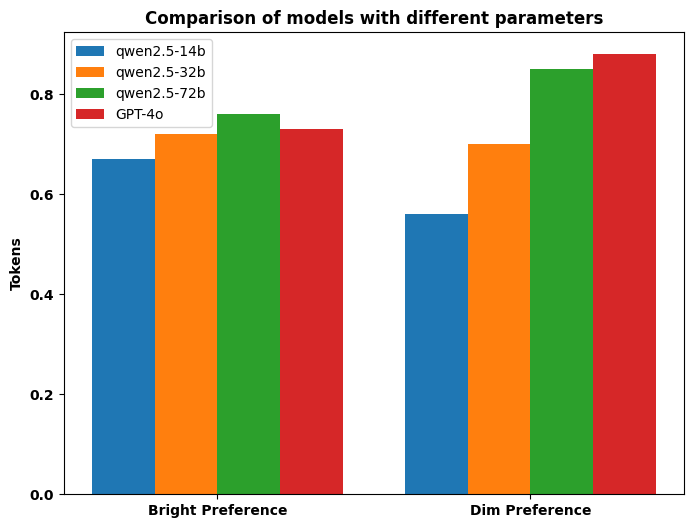

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data for accuracy of 5 methods across 3 rounds
methods = ['qwen2.5-14b', 'qwen2.5-32b', 'qwen2.5-72b','GPT-4o']
rounds = ['Bright Preference', 'Dim Preference']
accuracy_data = {
    'qwen2.5-14b': [0.67, 0.56],
    'qwen2.5-32b': [0.72, 0.70],
    'qwen2.5-72b': [0.76, 0.85],
    'GPT-4o': [0.73, 0.88]
}

# Number of methods
num_methods = len(methods)
bar_width = 0.2  # Width of the bars
index = np.arange(len(rounds))  # X locations for each round

# Plotting
plt.figure(figsize=(8, 6))
for i, (method, accuracies) in enumerate(accuracy_data.items()):
    plt.bar(index + i * bar_width, accuracies, bar_width, label=method)

# Labels and titles
# plt.xlabel('Token consumption of each round')
#bold the x and y labels
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.ylabel('Tokens', fontweight='bold')
plt.title('Comparison of models with different parameters', fontweight='bold')
plt.xticks(index + bar_width * (num_methods - 1) / 2, rounds)
plt.xticks(fontweight='bold')
plt.legend()
plt.savefig('14b32b72b.pdf')
plt.show()
